# 1. Path & Config
**Training notes: <br>**
for 150 epochs, we get slight overfitting (you can see this in the result.png photo at the val/dfl_loss graph)

In [28]:
# --- Paths & core config -------------------------------------------------------
from pathlib import Path
import yaml, time

PROJECT_ROOT = Path(r"D:/Ai Systems Group")
DATA_YAML    = PROJECT_ROOT / "data/weeds_yolo/data.yaml"
OUT_DIR      = PROJECT_ROOT / "work_dirs"

# Timestamped run name so nothing ever gets overwritten and runs stay organized
RUN_TAG = time.strftime("%Y%m%d-%H%M%S")

CFG = {
    "data": str(DATA_YAML),
    "model": "yolov8m.pt",    # medium model
    "epochs": 200,            # give v8m more runway than v8n
    "batch": 8,               # drop to 2 if you see CUDA OOM
    "imgsz": 832,             # good for small weeds (multiple of 32)
    "workers": 2,             # Windows-safe
    "device": 0,
    "project": str(OUT_DIR),
    "name": f"yolov8m-weeds_{RUN_TAG}",  # unique folder per run
    "exist_ok": False,        # auto-increment if same name somehow reused
    "plots": True,
    "patience": 30,
    "seed": 42,
    # "cache": "ram",         # enable only if you have plenty of system RAM
}

# --- Sanity checks -------------------------------------------------------------
assert DATA_YAML.exists(), f"Missing dataset yaml: {DATA_YAML}"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Config:\n", yaml.safe_dump(CFG, sort_keys=False))


Config:
 data: D:\Ai Systems Group\data\weeds_yolo\data.yaml
model: yolov8m.pt
epochs: 200
batch: 8
imgsz: 832
workers: 2
device: 0
project: D:\Ai Systems Group\work_dirs
name: yolov8m-weeds_20251030-112210
exist_ok: false
plots: true
patience: 30
seed: 42



# Inspec dataset YAML

In [29]:
with open(DATA_YAML, "r", encoding="utf-8") as f:
    ds = yaml.safe_load(f)
print(ds)


{'path': 'D:/Ai Systems Group/data/weeds_yolo', 'train': 'images/train', 'val': 'images/val', 'names': {0: 'Rose', 1: 'Weed'}}


# 2. Model Training


In [30]:
# --- Two-Stage YOLOv8m Training (Warmup -> Full) ---
from pathlib import Path
from ultralytics import YOLO

# === Stage 1: Warmup (freeze early layers) ===
print("==> Stage 1: Warmup from pretrained", CFG["model"])
model = YOLO(CFG["model"])

warm_results = model.train(
    data=CFG["data"],
    epochs=10,
    imgsz=CFG["imgsz"],
    batch=CFG["batch"],
    workers=CFG["workers"],
    device=CFG["device"],
    project=CFG["project"],
    name=f"{CFG['name']}-warmup",
    exist_ok=CFG["exist_ok"],
    patience=25,
    seed=CFG["seed"],
    plots=True,

    # Optimizer & schedule
    optimizer="AdamW",
    lr0=0.0008,
    cos_lr=True,
    lrf=0.01,
    momentum=0.9,
    weight_decay=0.0005,
    warmup_epochs=3,
    warmup_momentum=0.6,
    warmup_bias_lr=0.05,
    dropout=0.05,

    # Augmentations for small weeds (stronger early)
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    degrees=5.0, translate=0.1, scale=0.45, shear=2.0,
    perspective=0.0,
    flipud=0.0, fliplr=0.5,
    mosaic=0.6,                         # stronger mosaic in warmup
    mixup=0.05,                         # CHANGE: a bit more mixup
    copy_paste=0.10,                    # CHANGE: stronger copy-paste
    close_mosaic=5,                     # turn off mosaic near end of warmup
    freeze=10,                          # freeze early backbone
)

# === Stage 2: Full Training (unfreeze all layers) ===
WARM_WEIGHTS = Path(warm_results.save_dir) / "weights" / "last.pt"
print("==> Stage 2: Full training from warmup weights:", WARM_WEIGHTS)

model = YOLO(str(WARM_WEIGHTS))

results = model.train(
    data=CFG["data"],
    epochs=CFG["epochs"],
    imgsz=CFG["imgsz"],
    batch=CFG["batch"],
    workers=CFG["workers"],
    device=CFG["device"],
    project=CFG["project"],
    name=f"{CFG['name']}-fullyTrained",
    exist_ok=CFG["exist_ok"],
    patience=CFG["patience"],
    seed=CFG["seed"],
    plots=True,

    # Optimizer & schedule
    optimizer="AdamW",
    lr0=0.0008,
    cos_lr=True,
    lrf=0.01,
    momentum=0.9,
    weight_decay=0.0005,
    warmup_epochs=3,
    warmup_momentum=0.6,
    warmup_bias_lr=0.05,
    dropout=0.05,                       # CHANGE: mild dropout


    # Augmentations (moderate, then off longer at end)
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    degrees=5.0, translate=0.1, scale=0.45, shear=2.0,
    perspective=0.0,
    flipud=0.0, fliplr=0.5,
    mosaic=0.4,
    mixup=0.03,
    copy_paste=0.05,
    close_mosaic=20,                    # CHANGE: longer non-mosaic tail for 200 epochs
    freeze=0,
    multi_scale=True,                   # CHANGE: optional generalization boost
)

results


==> Stage 1: Warmup from pretrained yolov8m.pt
New https://pypi.org/project/ultralytics/8.3.222 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.220  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=5, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=D:\Ai Systems Group\data\weeds_yolo\data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.05, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=832, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0008, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.05, mode=train, model=yolov8m.pt, mo

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000124248D06A0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
       0.04504505, 0.04604605, 0.04704705, 0.048

# 3. View trianing curves

Found run folders:
  ✅ yolov8m-weeds_20251030-112210-warmup
  ✅ yolov8m-weeds_20251030-112210-fullyTrained

Latest suitable run: yolov8m-weeds_20251030-112210-fullyTrained


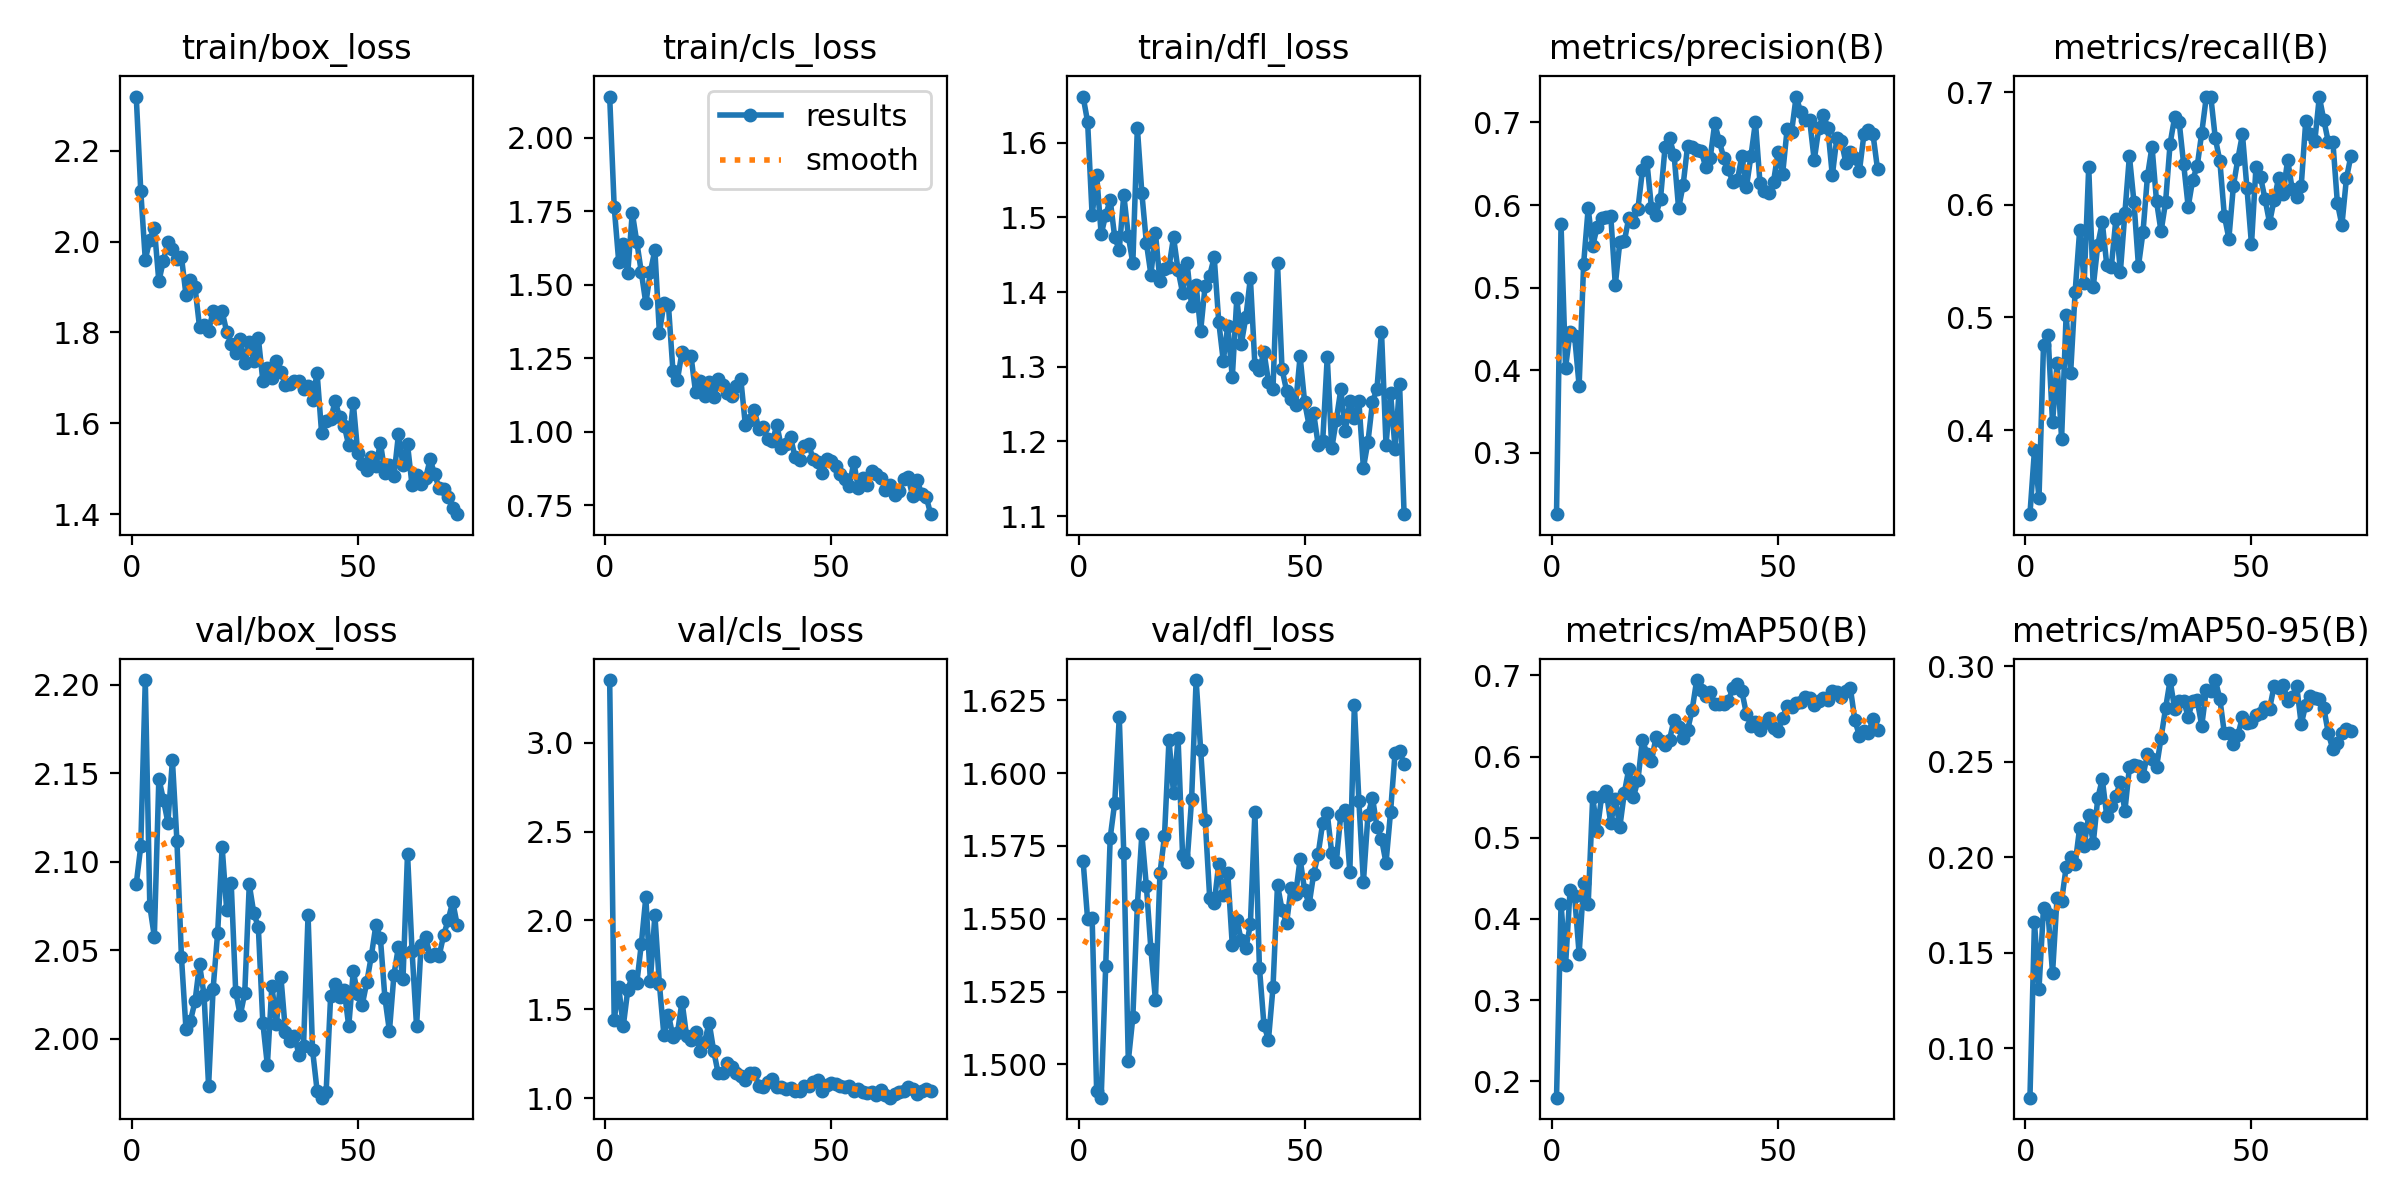

In [31]:
# --- Display latest YOLO training curves (results.png) ---
from IPython.display import display
from PIL import Image
import os

base = CFG["name"]
candidates = [
    d for d in OUT_DIR.iterdir()
    if d.is_dir() and d.name.startswith(base)
    and "-pred" not in d.name and "-val" not in d.name
]

if candidates:
    def score_dir(p):
        has_results = (p / "results.png").exists()
        return (has_results, os.path.getmtime(p))

    best = sorted(candidates, key=score_dir)[-1]
    img_path = best / "results.png"

    print("Found run folders:")
    for d in sorted(candidates, key=os.path.getmtime):
        marker = "✅" if (d / "results.png").exists() else "—"
        print(f"  {marker} {d.name}")

    print(f"\nLatest suitable run: {best.name}")
    if img_path.exists():
        display(Image.open(img_path))
    else:
        print("results.png not found in:", img_path)
else:
    print(f"No run folders found for '{base}'.")


# 4. Validate on val set (metrics + plots)

In [32]:
# --- Validate latest trained YOLO model on the val set ---
from ultralytics import YOLO
import os

subdirs = [d for d in OUT_DIR.glob("yolov8m-weeds_*") if d.is_dir()]
latest_run = max(subdirs, key=os.path.getmtime)
best_weights = latest_run / "weights" / "best.pt"

print(f"Validating model from: {best_weights}")

model = YOLO(str(best_weights))
metrics = model.val(
    data=CFG["data"],
    project=str(OUT_DIR),
    name=f"{latest_run.name}-val",
    plots=True
)

print("\nValidation complete ✅")
print(f"Results saved to: {metrics.save_dir}")
metrics


Validating model from: D:\Ai Systems Group\work_dirs\yolov8m-weeds_20251030-112210-fullyTrained\weights\best.pt
Ultralytics 8.3.220  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 2699.5368.1 MB/s, size: 7655.7 KB)
val: Scanning D:\Ai Systems Group\data\weeds_yolo\labels\val.cache... 43 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 43/43 43.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 0.4it/s 7.2s2.3ss
                   all         43        801      0.649      0.669       0.68      0.293
                  Rose         43        177      0.585       0.65      0.625       0.25
                  Weed         43        624      0.713      0.689      0.735      0.335
Speed: 2.7ms preprocess, 27.2ms inference, 0.0ms loss, 4.7ms postproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000124219554E0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
       0.04504505, 0.04604605, 0.04704705, 0.048

# 5. Predict on some images

In [33]:
# --- Predict on validation images using the latest training weights ---
from ultralytics import YOLO
from pathlib import Path
import os, yaml

exp_name = CFG["name"]
candidates = [
    d for d in OUT_DIR.iterdir()
    if d.is_dir()
    and d.name.startswith(exp_name)
    and "-val" not in d.name and "-pred" not in d.name
    and (d / "weights").exists()
]

def run_score(p: Path):
    best = p / "weights" / "best.pt"
    last = p / "weights" / "last.pt"
    has_best = best.exists()
    ref = best if has_best else (last if last.exists() else p)
    return (has_best, os.path.getmtime(ref))

latest_run = sorted(candidates, key=run_score)[-1]
best_weights = latest_run / "weights" / "best.pt"
last_weights = latest_run / "weights" / "last.pt"

weights_path = best_weights if best_weights.exists() else last_weights
print(f"Using weights: {weights_path}")

with open(DATA_YAML, "r", encoding="utf-8") as f:
    ds = yaml.safe_load(f)

base_path = Path(ds.get("path", "")) if ds.get("path") else DATA_YAML.parent
VAL_IMAGES = (base_path / ds["val"]).resolve()

print(f"Predicting on: {VAL_IMAGES}")
print(f"Run folder:     {latest_run.name}")

model = YOLO(str(weights_path))
pred = model.predict(
    source=str(VAL_IMAGES),
    project=str(OUT_DIR),
    name=f"{latest_run.name}-pred",
    save=True,
    save_txt=True,
    conf=0.25,
    imgsz=CFG["imgsz"],
)

print(f"\nPredictions saved to: {OUT_DIR / (latest_run.name + '-pred')}")
pred[:2]


Using weights: D:\Ai Systems Group\work_dirs\yolov8m-weeds_20251030-112210-fullyTrained\weights\best.pt
Predicting on: D:\Ai Systems Group\data\weeds_yolo\images\val
Run folder:     yolov8m-weeds_20251030-112210-fullyTrained

image 1/43 D:\Ai Systems Group\data\weeds_yolo\images\val\00c6243d-IMG_3347.JPG: 640x832 7 Roses, 31.4ms
image 2/43 D:\Ai Systems Group\data\weeds_yolo\images\val\127ca570-DJI_0213.JPG: 480x832 8 Roses, 20 Weeds, 22.7ms
image 3/43 D:\Ai Systems Group\data\weeds_yolo\images\val\149e798d-IMG_3340.JPG: 640x832 6 Roses, 4 Weeds, 33.9ms
image 4/43 D:\Ai Systems Group\data\weeds_yolo\images\val\1f9a191e-DJI_0215.JPG: 480x832 7 Roses, 23 Weeds, 22.5ms
image 5/43 D:\Ai Systems Group\data\weeds_yolo\images\val\26e9134d-DJI_0199.JPG: 480x832 9 Roses, 15 Weeds, 22.6ms
image 6/43 D:\Ai Systems Group\data\weeds_yolo\images\val\2ab9900c-IMG_3303.JPG: 640x832 6 Roses, 5 Weeds, 33.8ms
image 7/43 D:\Ai Systems Group\data\weeds_yolo\images\val\30b69407-IMG_3305.JPG: 640x832 5 Roses

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Rose', 1: 'Weed'}
 obb: None
 orig_img: array([[[ 87, 101, 100],
         [ 91, 105, 104],
         [ 88, 102, 101],
         ...,
         [101, 100, 104],
         [104, 105, 109],
         [154, 155, 159]],
 
        [[ 77,  91,  90],
         [ 77,  91,  90],
         [ 75,  89,  88],
         ...,
         [ 91,  92,  96],
         [111, 112, 116],
         [167, 168, 172]],
 
        [[ 63,  75,  75],
         [ 60,  72,  72],
         [ 68,  80,  80],
         ...,
         [ 95,  96, 100],
         [132, 135, 139],
         [193, 196, 200]],
 
        ...,
 
        [[ 89,  65,  45],
         [ 92,  68,  48],
         [ 91,  67,  47],
         ...,
         [112, 117, 120],
         [ 97, 100, 104],
         [122, 125, 129]],
 
        [[ 88,  64,  44],
         [ 91,  67,  47],
         [ 91,  68,  46],
         ...,
         